In [1]:
import pandas as pd
import numpy as np
import os
import json
import ast
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stop_words = list(stopwords.words('english'))
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint
import pyLDAvis.gensim
import pickle
import pyLDAvis
import time
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem import WordNetLemmatizer
from itertools import combinations
nltk.download('wordnet')
import networkx as nx
from node2vec import Node2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pi96a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pi96a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
path = "C:/Drive D/Datasets/Aminer Data"
os.chdir(path)

In [3]:
topic_words_df = pd.read_csv("new_dblp-ref-3 LDA topic words.csv")

In [4]:
topic_words_df.drop(['Unnamed: 0'], axis = "columns", inplace = True)

In [5]:
doc_topic_df = pd.read_csv("new_dblp-ref-3 doc-topic-df.csv")

In [6]:
df = pd.read_json("new_dblp-ref-3.json")
print(df.shape)
df.isnull().sum()

(79007, 8)


abstract      34037
authors           0
n_citation        0
references    29461
title             0
venue             0
year              0
id                0
dtype: int64

In [7]:
%%time
# Removing all the Null values from the dataset

# drop all NA values from the dataset
print("Before Dropping NA : ", df.shape)
df = df.dropna().reset_index(drop = True)
print("After Dropping NA : ", df.shape)

Before Dropping NA :  (79007, 8)
After Dropping NA :  (35174, 8)
CPU times: total: 46.9 ms
Wall time: 106 ms


In [8]:
df = pd.concat([doc_topic_df[['Topic']], df], axis = "columns")

In [9]:
# hybrid system:
# - extract text based features
# - extract graph based features
# - concatenate both these features within the LDA identified groups
# - use kmeans to identify the potential similar papers nearby

### Finding papers where the references exists between id and references

In [10]:
id_library = df["id"].values.tolist()

In [11]:
id_inter_reference = list(set(chain.from_iterable(df["references"].values.tolist())).intersection(id_library))

In [12]:
refernce_sub_df = df[df["id"].isin(id_inter_reference)].reset_index(drop = True)

In [13]:
refernce_sub_df["Paper_Id"] = [f"Paper_{i}" for i in range(refernce_sub_df.shape[0])]

In [14]:
refernce_sub_df.head()

,Topic,abstract,authors,n_citation,references,title,venue,year,id,Paper_Id
0,4,For stereoscopic optical see-through head-moun...,"[Long Qian, Alexander Winkler, Bernhard Fuerst...",50,"[076bca9b-b30c-4c2c-8148-3b9b5d9aa939, 6b5cf40...",Modeling Physical Structure as Additional Cons...,international symposium on mixed and augmented...,2016,01f02fae-97df-4207-a386-a1bc8ec0853b,Paper_0
1,2,For the multiterminal secret key agreement pro...,"[Chung Chan, Manuj Mukherjee, Navin Kashyap, Q...",50,"[19eb4d23-c01f-484a-ad86-0f1061622295, 205c230...",Secret Key Agreement under Discussion Rate Con...,arXiv: Information Theory,2017,0600c67e-71a1-4ed2-913f-e9db02370de4,Paper_1
2,4,Semantic image segmentation is a fundamental t...,"[Tong Shen, Guosheng Lin, Chunhua Shen, Ian D....",50,"[031bbeb0-4dc1-46f9-9984-109c3b3eefae, 153c501...",Learning Multi-level Region Consistency with D...,arXiv: Computer Vision and Pattern Recognition,2017,0a2562d0-f2af-47e1-a783-02aac8607c7b,Paper_2
3,3,Data analytics frameworks shift towards larger...,"[Jinwei Liu, Haiying Shen]",50,"[004b7183-1fb5-4e08-b29a-87c679316171, 0150e04...",Dependency-Aware and Resource-Efficient Schedu...,ieee international conference on cloud computi...,2016,11997fa1-0571-413a-bacd-4ae3162353dd,Paper_3
4,5,Human cognitive performance is critical to pro...,"[Tim Althoff, Eric Horvitz, Ryen W. White, Jam...",50,"[0a2ad8d5-373a-44fb-8daf-28fbd4fd3efd, 1515814...",Harnessing the Web for Population-Scale Physio...,international world wide web conferences,2017,237ec7a8-aa9b-4c98-9612-bd98450d0747,Paper_4


## ID-Reference Graph Features

In [15]:
id_reference = []
temp_id_library = refernce_sub_df["id"].values.tolist()
for key, references in zip(refernce_sub_df["id"], refernce_sub_df["references"]):
    for reference in references:
        if reference in temp_id_library:
            id_reference.append((key, reference))

In [16]:
# id refernce graph
id_reference_graph = nx.Graph()

for edge in id_reference:
    id_reference_graph.add_edge(edge[0], edge[1])

In [17]:
#plt.figure(figsize = (15, 15))
#nx.draw_networkx(id_reference_graph, with_labels = False, arrows = True, node_size = 10)
#plt.axis('off')
#plt.title("Graph between paper id and references")
#plt.show()

### Text Features

In [18]:
# generating content column for each row in dataset
refernce_sub_df["Content"] = refernce_sub_df["abstract"].str.lower() + refernce_sub_df["title"].str.lower()

In [19]:
#sub_df = df.sample(1000, random_state = 23).reset_index(drop = True)

In [20]:
%%time
# Creating stop words list
stop_words_extended_list = ["the", "of", "and", "a", "in", "to", "is", 
                            "?", "for", "we", "that", "-", "=", "with", ",", 
                            "on", "as", "by", "are", "this", "be", ".", 
                            "can", "an", "from", ")", "which", "it", "+", 
                            "each", "our", "at", "where", "has", "such", 
                            "a", "b", "c", "d", "e", "f", "g", "h", "i",
                            "j", "k", "l", "m", "n", "o", "p", "q", "r",
                            "s", "t", "u", "v", "w", "x", "y", "z", 
                            "0", "1", "2", "3", "4", "5", "6", "7", "8", 
                            "9", "et", "j.", "", "(", "a)", "b)"]
english_stop_words.extend(stop_words_extended_list)
english_stop_words = set(english_stop_words)

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
%%time
def remove_stopwords(row):
    new_string = []
    for word in row.split(" "):
        if word in english_stop_words:
            continue
        else:
            new_string.append(word)
    return " ".join(new_string)

refernce_sub_df["Non Stop Word Content"] = refernce_sub_df["Content"].apply(remove_stopwords)

CPU times: total: 15.6 ms
Wall time: 87.8 ms


In [36]:
%%time
words_list = []
wordnet_lemmatizer = WordNetLemmatizer()
def perform_lemmatization(row):
    new_string = []
    for word in row.split(" "):
        lemmatized_word = wordnet_lemmatizer.lemmatize(word)
        words_list.append(lemmatized_word)
        new_string.append(lemmatized_word)
    return " ".join(new_string)

refernce_sub_df["lemmatized Content"] = refernce_sub_df["Non Stop Word Content"].apply(perform_lemmatization)

CPU times: total: 578 ms
Wall time: 1.11 s


In [53]:
word_counts_1000 = Counter(words_list).most_common(1500)

In [80]:
# word frequency dictionary
word_counts_dict = {w: c for (w,c) in word_counts_1000}

# word cloud object
wc = WordCloud(background_color = "white", height = 400, width = 1100)
wc.generate_from_frequencies(word_counts_dict)

C:\Users\pi96a\anaconda3\envs\EAS508\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


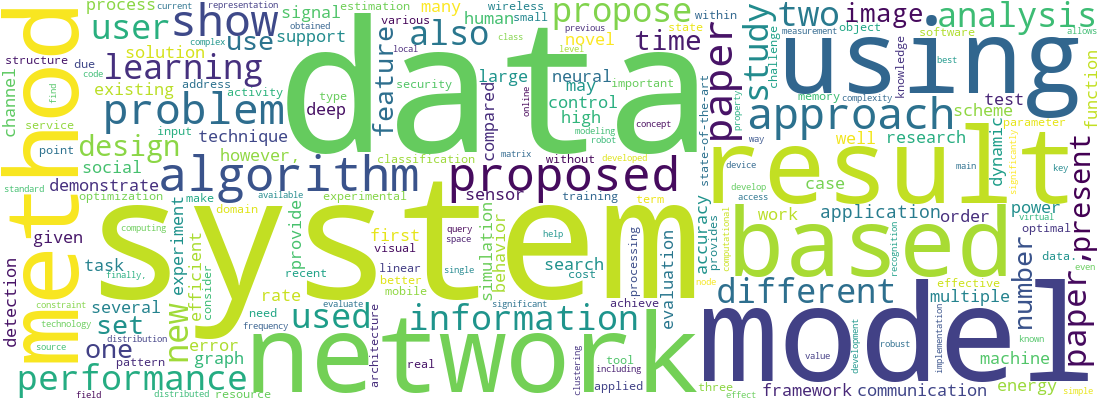

In [81]:
wc.to_image()

In [33]:
# TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english', min_df = 3)
tfidf_matrix = tfidf.fit_transform(refernce_sub_df["lemmatized Content"])
tfidf_matrix.shape

(1321, 4819)

### Graph based on Authors

In [24]:
# author based graph
all_unique_authors = list(set(chain.from_iterable(refernce_sub_df["authors"].values.tolist())))
len(all_unique_authors)

4505

In [25]:
authors_list = refernce_sub_df["authors"].values.tolist()

In [26]:
%%time
author_pairs = []
for author_sublist in authors_list:
    author_combinations = combinations(author_sublist, 2)
    for ac in author_combinations:
        if ac not in author_pairs:
            author_pairs.append(ac)

CPU times: total: 1.98 s
Wall time: 3.54 s


In [27]:
# authors graph
authors_graph = nx.Graph()

for edge in author_pairs:
    if edge[0] != edge[1]:
        authors_graph.add_edge(edge[0], edge[1])

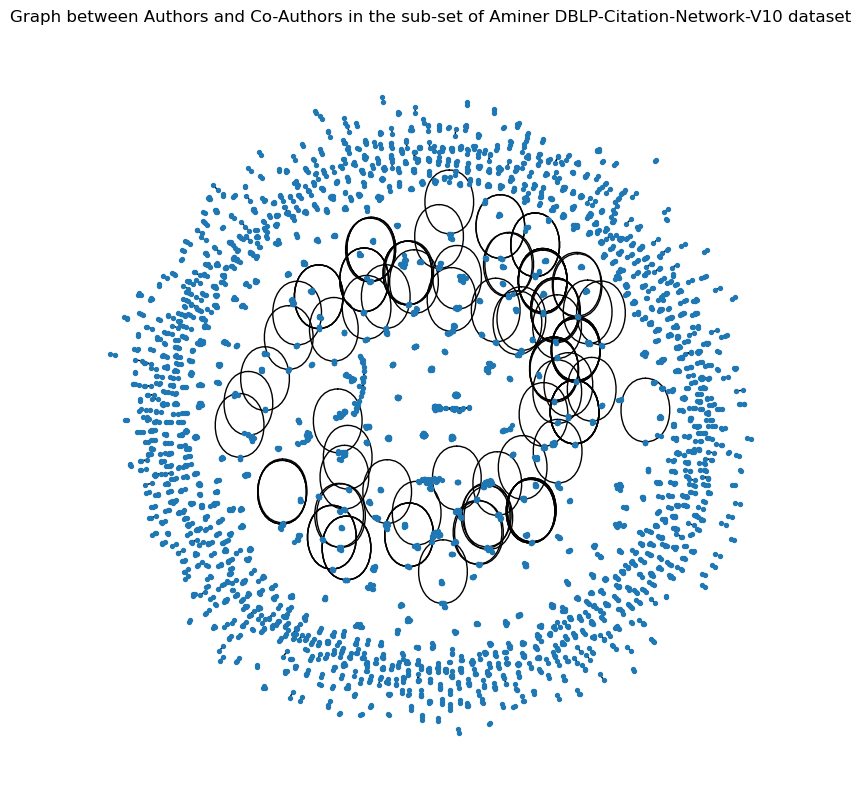

In [31]:
plt.figure(figsize = (10, 10))
nx.draw_networkx(authors_graph, with_labels = False, arrows = True, node_size = 8)
plt.axis('off')
plt.title("Graph between Authors and Co-Authors in the sub-set of Aminer DBLP-Citation-Network-V10 dataset")
plt.savefig("Author Graph.png", format = "png")
plt.show()

In [65]:
## Create a Node2Vec object for authors
#authors_node2vec = Node2Vec(authors_graph, dimensions=32, walk_length=30, num_walks=200, workers=4)
#
## Learn embeddings
#authors_model = authors_node2vec.fit(window=10, min_count=1, batch_words=4)
#
## Get the embeddings for all nodes in the graph
#embeddings = {node: authors_model.wv[node] for node in authors_graph.nodes}

In [56]:
# reading authors pickle files
with open('author-coauthor-graph-embeddings.pickle', "rb") as pickle_file:
    authors_embedding = pickle.load(pickle_file)
    
# reading references pickle files
with open('id-reference-graph-embeddings.pickle', "rb") as pickle_file:
    id_embedding = pickle.load(pickle_file)

In [57]:
def return_author_embeddings(row):
    authors_list = row["authors"]
    current_author_embedding = np.zeros((32,))
    for author in authors_list:
        try:
            current_author_embedding += authors_embedding[author]
        except:
            pass
    
    return current_author_embedding * 5

refernce_sub_df["Authors_Embedding"] = refernce_sub_df.apply(return_author_embeddings, axis = "columns")

In [58]:
refernce_sub_df.shape

(1321, 14)

In [59]:
embeddings_df = dict()
for i, values in enumerate(refernce_sub_df["Authors_Embedding"]):
    embeddings_df[f"Author_{i}"] = {k:v for k,v in zip(list(range(32)), values)}

In [60]:
content_tfidf_df = pd.DataFrame(tfidf_matrix.toarray())
print(content_tfidf_df.shape)
author_embedding_df = pd.DataFrame(embeddings_df).T.reset_index(drop = True)
print(author_embedding_df.shape)

(1321, 4819)
(1321, 32)


In [88]:
first_tfidf_vector = content_tfidf_df[0]
pd.DataFrame(first_tfidf_vector[np.where(first_tfidf_vector != 0.0)[0]]).T

,15,96,308,317,601,777,854,920,954,1033,1040
0,0.097773,0.112955,0.089403,0.114547,0.169919,0.064428,0.18738,0.156119,0.131297,0.09987,0.101894


In [201]:
combined_features_df = pd.concat([content_tfidf_df, author_embedding_df], axis = "columns")

In [202]:
cosine_sim_matrix = cosine_similarity(combined_features_df, combined_features_df)

In [203]:
cosine_sim_matrix

array([[1.        , 0.34036323, 0.47237545, ..., 0.55493331, 0.42708894,
        0.52434814],
       [0.34036323, 1.        , 0.38698448, ..., 0.54442469, 0.48837322,
        0.40985639],
       [0.47237545, 0.38698448, 1.        , ..., 0.42355572, 0.2839023 ,
        0.40474755],
       ...,
       [0.55493331, 0.54442469, 0.42355572, ..., 1.        , 0.27306605,
        0.60067133],
       [0.42708894, 0.48837322, 0.2839023 , ..., 0.27306605, 1.        ,
        0.30251262],
       [0.52434814, 0.40985639, 0.40474755, ..., 0.60067133, 0.30251262,
        1.        ]])

### Search

In [204]:
# search parameters
#search_parameter = input("Enter the keywords you want to search papers for: ")
search_parameter = "machines, computers, mathematics, studies, investigated"

In [205]:
keywords = [word.split(" ") for word in search_parameter.split(",")]
keywords = list(chain.from_iterable(keywords))
keywords = [word for word in keywords if word.isalpha()]
keywords

['machines', 'computers', 'mathematics', 'studies', 'investigated']

In [206]:
def return_search_topics(keywords):
    search_index = {}
    for col in topic_words_df.columns:
        intersection_number = len(set(keywords).intersection(set(topic_words_df[col].values)))
        if intersection_number > 0:
            search_index[col] = (intersection_number / len(set(topic_words_df[col].values))) * 100
    search_index = [int(index.split("_")[1]) for index in search_index.keys()]
    return search_index

In [207]:
search_index = return_search_topics(keywords)

In [208]:
# initial search results based on citations
refernce_sub_df[refernce_sub_df["Topic"].isin(search_index)].sort_values(["n_citation"], ascending = False).head(10)

,Topic,abstract,authors,n_citation,references,title,venue,year,id,Content,Non Stop Word Content,lemmatized Content,Paper_Id,id_embedding,Authors_Embedding
1148,5,Adaptive hypermedia is a relatively new direct...,[Peter Brusilovsky],3192,"[01c65f07-9d53-4844-8e25-ada6745a05d8, 13ca496...",Adaptive Hypermedia,,2001,8ab23f4b-0b87-42ed-9922-dbd10d9e845d,adaptive hypermedia is a relatively new direct...,adaptive hypermedia relatively new direction r...,adaptive hypermedia relatively new direction r...,Paper_1148,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1138,5,In 1977 Dalenius articulated a desideratum for...,[Cynthia Dwork],2390,"[32fd9fa0-0857-4bbc-8e40-b947c02e9d8b, 396c619...",Differential privacy,,2006,70f4dcf0-2784-4627-899c-1463988a3f52,in 1977 dalenius articulated a desideratum for...,1977 dalenius articulated desideratum statisti...,1977 dalenius articulated desideratum statisti...,Paper_1138,"[1.5262446, -1.2007257, 0.55819947, -0.0583931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1219,5,WordNet: Similarity is a freely available soft...,"[Ted Pedersen, Siddharth Patwardhan, Jason Mic...",1526,"[11d6d688-f542-4d4e-8a9e-50150c7f08e3, 4a23bcc...",WordNet: similarity - measuring the relatednes...,national conference on artificial intelligence,2004,ccd672d4-2f77-471e-abfc-cae8abd6ec16,wordnet: similarity is a freely available soft...,wordnet: similarity freely available software ...,wordnet: similarity freely available software ...,Paper_1219,NaN,"[24.85698699951172, -15.703827142715454, 14.42..."
1294,5,Abstract As computation continues to move into...,"[Luiz André Barroso, Jimmy Clidaras, Urs Hölzle]",1030,"[030d5be6-55f2-4776-85fd-c8924e5fac85, 047acff...",The Datacenter as a Computer: An Introduction ...,Synthesis Lectures on Computer Architecture,2013,f4e7237a-95e1-46c6-9d38-0d3ab22e528d,abstract as computation continues to move into...,"abstract computation continues move cloud, com...","abstract computation continues move cloud, com...",Paper_1294,NaN,"[-14.271031022071838, -8.979507982730865, 22.2..."
1127,5,We show how to learn a deep graphical model of...,"[Ruslan Salakhutdinov, Geoffrey E. Hinton]",789,"[0ad38f3e-8131-4287-9e62-2b2ae77f47f7, 1ce7a9a...",Semantic hashing,,2009,4c5ed508-b6e5-4db5-a59f-00e1d88dc221,we show how to learn a deep graphical model of...,show learn deep graphical model word-count vec...,show learn deep graphical model word-count vec...,Paper_1127,"[0.92011905, -0.39291722, 0.20525321, -0.62439...","[4.331156462430954, -12.589365839958191, 10.11..."
787,5,We describe a new framework for distilling inf...,"[Lidia Mangu, Eric Brill, Andreas Stolcke]",755,"[067692a8-da25-4aab-844b-8c164ecdd3e1, 17e4ec9...",Finding consensus in speech recognition: word ...,Computer Speech & Language,2000,fd1b7494-7d07-4d38-a1fe-4ade1aec343c,we describe a new framework for distilling inf...,describe new framework distilling information ...,describe new framework distilling information ...,Paper_787,NaN,"[-7.029730826616287, -10.103902220726013, 18.5..."
1048,5,We describe a method for the automatic identif...,"[Joshua R. Tyler, Dennis M. Wilkinson, Bernard...",729,"[05332f60-3d2e-45bb-9ecd-a7c7aa7774dc, 270c2f1...",E-Mail as Spectroscopy: Automated Discovery of...,The Information Society,2005,940e7ab9-c036-4e6a-8942-b90dc6b9c339,we describe a method for the automatic identif...,describe method automatic identification commu...,describe method automatic identification commu...,Paper_1048,NaN,"[14.430164098739624, 14.786618947982788, 16.45..."
1211,5,A multidatabase system (MDBS) is a facility th...,"[Yuri Breitbart, Hector Garcia-Molina, Abraham...",655,"[033b8897-3fa9-4d8e-bbfb-0a46a7c6651d, 07e8568...",Overview of multidatabase transaction management,very large data bases,1992,956c6250-c1d5-4f70-bbc7-8e8901b7885a,a multidatabase system (mdbs) is a facility th...,multidatabase system (mdbs) facility allows us...,multidatabase system (mdbs) facility allows us...,Paper_1211,NaN,"[9.67963188

In [209]:
index_number = 1148

# get the details of the paper which matches the index number
selected_paper = refernce_sub_df[refernce_sub_df.index == index_number]
    
# get the pairwise similarity score of all the papers with the selected paper
sim_scores = list(enumerate(cosine_sim_matrix[index_number]))

# sort the similar papers based on the similarity score
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)

# get the scores of the 10 most similar papers
sim_scores = sim_scores[1:11]

# get the indices of similar papers
sim_indices = [i[0] for i in sim_scores]

sim_indices

[10, 1205, 34, 249, 1233, 741, 1089, 689, 1196, 791]

In [210]:
temp_df = refernce_sub_df.reset_index()
temp_df[temp_df['index'].isin(sim_indices)]

,index,Topic,abstract,authors,n_citation,references,title,venue,year,id,Content,Non Stop Word Content,lemmatized Content,Paper_Id,id_embedding,Authors_Embedding
10,10,5,Abstract Context of altmetrics data is essenti...,[Houqiang Yu],50,"[0ebe665e-86f2-4e86-8d98-3565c771a024, 17f22da...",Context of altmetrics data matters: an investi...,Scientometrics,2017,6cb54358-913b-485f-8caa-b5a118fb5875,abstract context of altmetrics data is essenti...,abstract context altmetrics data essential und...,abstract context altmetrics data essential und...,Paper_10,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34,34,5,Model learning emerges as an effective method ...,[Frits W. Vaandrager],50,"[00cd344e-924d-4ba4-abb4-a74169684886, 047fc52...",Model learning,Communications of The ACM,2017,e7d9127a-4593-4b8f-a650-7c4d42078d28,model learning emerges as an effective method ...,model learning emerges effective method black-...,model learning emerges effective method black-...,Paper_34,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
249,249,5,Although scholars have long studied knowledge ...,[Shahla Ghobadi],50,"[0331f459-20b4-479a-a137-0c4b9e5cc973, 0510296...",What drives knowledge sharing in software deve...,Information & Management,2015,b604dadf-838d-4356-926d-96dd8c317ec6,although scholars have long studied knowledge ...,although scholars long studied knowledge shari...,although scholar long studied knowledge sharin...,Paper_249,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
689,689,5,"In this position paper, we address the questio...",[Markus Schedl],50,"[05bbaec3-7980-4941-8638-2bbfa4ac8be0, 200510c...",Intelligent User Interfaces for Social Music D...,,2017,91e176c1-e3a3-4228-bcf4-95e6357af558,"in this position paper, we address the questio...","position paper, address question make music se...","position paper, address question make music se...",Paper_689,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
741,741,5,This paper uncovers patterns of knowledge diss...,[Erjia Yan],22,"[088a2755-7152-45c3-937a-bf8c98699c61, 0970e01...",Finding knowledge paths among scientific disci...,Journal of the Association for Information Sci...,2014,c89f118a-9f38-45ac-8602-a9e503708b36,this paper uncovers patterns of knowledge diss...,paper uncovers patterns knowledge disseminatio...,paper uncovers pattern knowledge dissemination...,Paper_741,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
791,791,4,"In this work, we build a generic architecture ...",[Edouard Oyallon],50,"[038de7c2-5aeb-40ef-ab1e-5921773486da, 22b8673...",Building a Regular Decision Boundary with Deep...,arXiv: Computer Vision and Pattern Recognition,2017,2edda4ad-5098-4f38-8e41-c691fc7509b7,"in this work, we build a generic architecture ...","work, build generic architecture convolutional...","work, build generic architecture convolutional...",Paper_791,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1089,1089,0,The present contribution advances an abstract ...,[Daniel Găină],50,"[0b43a46e-24a6-4194-9ce2-ac75fc9277f8, 16c6248...",Foundations of logic programming in hybrid log...,Theoretical Computer Science,2017,5f291afe-6d80-439d-9752-1a8cf57899fd,the present contribution advances an abstract ...,present contribution advances abstract notion ...,present contribution advance abstract notion h...,Paper_1089,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1196,1196,5,Abstract The increasing use of digital media...,[Petra Perner],50,"[068f10f8-11a0-4c33-9e60-24c2db583af4, 09277be...",Mining Sparse and Big Data by Case-based Reaso...,Procedia Computer Science,2014,47e3e3be-647b-428b-91f7-b321405579dc,abstract the increasing use of digital media...,abstract increasing use digital media daily li...,abstract increasing use digital medium daily l...,Paper_1196,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1205,1205,3,Authentication schemes assure that authorised ...,[Mohammad Sabzinejad Farash],50,"[1b223a8d-79fd-4b7b-b456-d87eac3466